In [3]:
import sys, os
import copy
import re

import pickle as pkl
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

# Load Data

In [ ]:

MIN_NUM_READS = 100
PREDICT_RESULTS_D = "./predict_results"

#XCRISP_PREDICTIONS_F = "/Users/colm/repos/output/local/model_predictions/X-CRISP/XCRISP_mse_0.01__{}.pkl"
# XCRISP_KLD_PREDICTIONS_F = "C:/Users/18379\Desktop\XCRISP-main\src\models\XCRISP\outputmodel_predictions\X-CRISP\XCRISP_0_KL_Div_0.01__{}.pkl"
# LINDEL_PREDICTIONS_F = "C:/Users/18379\Desktop\XCRISP-main\src\models\Lindel\output\model_predictions\Lindel\Lindel_{}.pkl"
# FORECasT_PREDICTIONS_F = "C:/Users/18379\Desktop\XCRISP-main\src\models\FORECasT\output\model_predictions\FORECasT\predictions_100x_{}.pkl"
# INDELPHI_PREDICTIONS_F = "C:/Users/18379\Desktop\XCRISP-main\src\models\inDelphi\output\model_predictions\inDelphi\{}_predictions.pkl"
XCRISP_tabm_PREDICTIONS_F = PREDICT_RESULTS_D + "DuAxis/XCRISP_testmask_deldualmodelWKL0.25_insTCN_sequenceonly_KL_Div_0.01__{}.pkl"
# TEST_FILES = ["test", "0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1", "052218-U2OS-+-LibA-postCas9-rep1_transfertest", "0226-PRLmESC-Lib1-Cas9_transfertest", "TREX_A_test", "HAP1_test"]
TEST_FILES = ["test", "0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1"]#, "0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1"
BASELINE_TEST_FILES = ["test"]#, "0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1"
data = {}

for i, t in enumerate(TEST_FILES):
    data[t] = {}
    #data[t]["X-CRISP-MSE"] = pkl.load(open(XCRISP_PREDICTIONS_F.format(t), 'rb'))
    # data[t]["X-CRISP"] = pkl.load(open(XCRISP_KLD_PREDICTIONS_F.format(t), 'rb'))
    #data[t]["inDelphi"] = pkl.load(open(INDELPHI_PREDICTIONS_F.format(t), 'rb'))
    # data[t]["Lindel"] = pkl.load(open(LINDEL_PREDICTIONS_F.format(t), 'rb'))
    # data[t]["FORECasT"] = pkl.load(open(FORECasT_PREDICTIONS_F.format(t), 'rb'))
    data[t]["DU-AxisCRISP"]=pkl.load(open(XCRISP_tabm_PREDICTIONS_F.format(t), 'rb'))

    # need to remove psuedocounts that were added to profiles in preparation for training
    for target_site in data[t]["FORECasT"].keys():
        data[t]["FORECasT"][target_site]["actual"] = np.array(data[t]["FORECasT"][target_site]["actual"]) - 0.5

models = list(data[t].keys())
print(models, "loaded")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/18379\\Desktop\\XCRISP-main\\src\\models\\XCRISP\\outputmodel_predictions\\X-CRISP\\XCRISP_testmask_deldualmodelWKL0.25_insTCN_sequenceonly_KL_Div_0.01__test.pkl'

In [ ]:
t = "052218-U2OS-+-LibA-postCas9-rep1_transfertest"
method = "X-CRISP-MSE"
target_site = "0_0_0_0_AAATATCTTTAACCTAAAAC"
print(t, method, target_site)

In [54]:
for t in TEST_FILES:
    for m in models:
        target_site = list(data[t][m].keys())[0]
        for k in data[t][m][target_site].keys():
            print(t, m, target_site, len(data[t][m][target_site][k]))

test X-CRISP Oligo_43170 434
test X-CRISP Oligo_43170 434
test X-CRISP Oligo_43170 434
test X-CRISP Oligo_43170 434
test inDelphi Oligo_43170 107
test inDelphi Oligo_43170 107
test inDelphi Oligo_43170 107
test inDelphi Oligo_43170 107
test Lindel Oligo_43170 557
test Lindel Oligo_43170 557
test Lindel Oligo_43170 557
test Lindel Oligo_43170 557
test FORECasT Oligo_43170 398
test FORECasT Oligo_43170 398
test FORECasT Oligo_43170 398
test FORECasT Oligo_43170 398
test DU-AxisCRISP Oligo_43170 434
test DU-AxisCRISP Oligo_43170 434
test DU-AxisCRISP Oligo_43170 434
test DU-AxisCRISP Oligo_43170 434
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 X-CRISP 0_0_0_0_CTTTCACTTTATAGATTTAT 393
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 X-CRISP 0_0_0_0_CTTTCACTTTATAGATTTAT 393
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 X-CRISP 0_0_0_0_CTTTCACTTTATAGATTTAT 393
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 X-CRISP 0_0_0_0_CTTTCACTTTATAGATTTAT 393
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 inDelphi 0_0_0_0_CTTTC

### Reformat files

In [55]:
for t in TEST_FILES:
    for e in data[t]:
        print(t, e, len(data[t][e].keys()))

# collect targets common to all experiments

from functools import reduce
common_oligos = {}


for t in TEST_FILES:
    ts = []
    ts.append(list(data[t]["Lindel"].keys()))
    ts.append(list(data[t]["inDelphi"].keys()))
    ts.append(list(data[t]["FORECasT"].keys()))
    common_oligos[t] = reduce(np.intersect1d, ts)
    print(f"There are {len(common_oligos[t])} oligos common to {t}")

# reformat FORECasT indels
def FC_indel_to_our(fc):
    parts = fc.split("_")
    print(parts)
    t = parts[0][0] # type I or D 
    l = int(parts[0][1:]) # size
    p = int(parts[1].split("R")[1]) # start
    if t == "D":
        return "{}+{}".format(p-l, l)
    else:
        # return "I{}".format(l)
        return fc

def inDelphi_to_our(ind):
    if ind[-1] in "ACGT":
        return "1+" + ind[-1]
    if ind.isnumeric():
        return "DL" + ind 
    return ind

for t in TEST_FILES:
    for o in common_oligos[t]:
        if "FORECasT" in data[t]:
            data[t]["FORECasT"][o]["indels"] = [FC_indel_to_our(i) for i in data[t]["FORECasT"][o]["indels"]]
        if "inDelphi" in data[t]:
            data[t]["inDelphi"][o]["indels"] = [inDelphi_to_our(i) for i in data[t]["inDelphi"][o]["indels"]]

# np.seterr(all='raise')
file_mapping = {
    "test": "FORECasT WT",
    "0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1": "inDelphi WT",
    "WT": "LUMC WT",
    "0226-PRLmESC-Lib1-Cas9_transfertest": "inDelphi NHEJ-deficient",
    "052218-U2OS-+-LibA-postCas9-rep1_transfertest": "inDelphi USO2 WT",
    "HAP1_test": "FORECasT HAP1",
    "TREX_A_test": "FORECasT TREX",
    "2A_TREX_A_test": "2A_FORECasT TREX",
}

test X-CRISP 3928
test inDelphi 3701
test Lindel 3896
test FORECasT 4304
test DU-AxisCRISP 3928
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 X-CRISP 1991
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 inDelphi 1987
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 Lindel 1991
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 FORECasT 1959
0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1 DU-AxisCRISP 1991
There are 3699 oligos common to test
There are 1954 oligos common to 0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1
['D10', 'L-10R1']
['D10', 'L-12C1R0']
['D10', 'L-1R10']
['D10', 'L-2R9']
['D10', 'L-3R8']
['D10', 'L-4R7']
['D10', 'L-6C1R6']
['D10', 'L-7R4']
['D10', 'L-8R3']
['D10', 'L-9R2']
['D11', 'L-10C1R3']
['D11', 'L-12C1R1']
['D11', 'L-1R11']
['D11', 'L-2R10']
['D11', 'L-3R9']
['D11', 'L-4R8']
['D11', 'L-5R7']
['D11', 'L-6R6']
['D11', 'L-8C1R5']
['D12', 'L-10R3']
['D12', 'L-11R2']
['D12', 'L-12R1']
['D12', 'L-13R0']
['D12', 'L-1R12']
['D12', 'L-2R11']
['D12', 'L-5C2R10']
['D12', 'L-6R7']
['D12', 'L-9C2R6']
['D13', 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




['D27', 'L-26R2']
['D27', 'L-27R1']
['D27', 'L-29C1R0']
['D27', 'L-3C1R26']
['D27', 'L-4R24']
['D27', 'L-5R23']
['D27', 'L-6R22']
['D27', 'L-8C1R21']
['D27', 'L-9R19']
['D28', 'L-10R19']
['D28', 'L-11R18']
['D28', 'L-13C1R17']
['D28', 'L-16C2R15']
['D28', 'L-18C1R12']
['D28', 'L-19R10']
['D28', 'L-20R9']
['D28', 'L-22C1R8']
['D28', 'L-24C1R6']
['D28', 'L-25R4']
['D28', 'L-26R3']
['D28', 'L-27R2']
['D28', 'L-29C1R1']
['D28', 'L-2C1R28']
['D28', 'L-3R26']
['D28', 'L-5C1R25']
['D28', 'L-6R23']
['D28', 'L-7R22']
['D28', 'L-8R21']
['D28', 'L-9R20']
['D29', 'L-13C3R20']
['D29', 'L-15C1R16']
['D29', 'L-16R14']
['D29', 'L-17R13']
['D29', 'L-18R12']
['D29', 'L-19R11']
['D29', 'L-1C1R30']
['D29', 'L-20R10']
['D29', 'L-23C2R9']
['D29', 'L-24R6']
['D29', 'L-25R5']
['D29', 'L-26R4']
['D29', 'L-28C1R3']
['D29', 'L-29R1']
['D29', 'L-31C1R0']
['D29', 'L-6C4R28']
['D29', 'L-7R23']
['D29', 'L-8R22']
['D29', 'L-9R21']
['D2', 'L-1R2']
['D2', 'L-3C1R1']
['D30', 'L-11C1R21']
['D30', 'L-12R19']
['D30', 'L-1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Generate ins mappings to FORECasT output 

In [56]:
import re
sys.path.append("C:/Users/18379\Desktop\XCRISP-main")
from src.data.data_loader import get_details_from_fasta

# test over a common set of indels per target site
def generate_1_and_2_bp_insertions():
    nucs = ["A", "C", "G", "T"]
    onebps = []
    twobps = []
    for n1 in nucs:
        onebps.append("1+" + n1)
        for n2 in nucs:
            twobps.append("2+" + n1 + n2)
    return onebps + twobps

common_insertions = generate_1_and_2_bp_insertions()

fasta_files = ["C:/Users/18379\Desktop\XCRISP-main\src\data\FORECasT/test.fasta", "C:/Users/18379\Desktop\XCRISP-main/src/data/inDelphi/LibA.fasta"]#, "../../src/data/inDelphi/LibA.fasta"
guides = {}

for ff in fasta_files:
    guides.update(get_details_from_fasta(ff))

ins_mapping = {}
t = "test"
for t in TEST_FILES:
    ins_mapping[t] = {}
    for o in common_oligos[t]:
        g = guides[o]
        cutsite = g["PAM Index"] - 3
        ins_mapping[t][o] = {}
        FORECasT_insertions = [i for i in data[t]["FORECasT"][o]["indels"] if "I" in i]
        FORECasT_rep_insertions = [i for i in FORECasT_insertions if "C" in i]
        FORECasT_norep_insertions = [i for i in FORECasT_insertions if "C" not in i]
        if len(FORECasT_norep_insertions) not in [1, 2]: print("wtf")
        for i in FORECasT_rep_insertions:
            _, I, _, L, C, R = re.split("I|_|L|C|R", i)
            rep_nuc = g["TargetSequence"][cutsite + int(R) -int(I):cutsite + int(R)]
            ins_mapping[t][o][i] = "{}+{}".format(int(I), rep_nuc)
        for i in FORECasT_norep_insertions:
            if i[1] == "1":
                ins_mapping[t][o][i] = list(np.setdiff1d([c for c in common_insertions if "1" in c], list(ins_mapping[t][o].values()))) 
            if i[1] == "2":
                ins_mapping[t][o][i] = list(np.setdiff1d([c for c in common_insertions if "2" in c], [c for c in list(ins_mapping[t][o].values()) if "2" in c])) 
print("mapped output to FORECasT")
print(ins_mapping[t][o])

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
C:\Users\18379\AppData\Local\Temp\ipykernel_7456\1318156812.py:2: SyntaxWarning: invalid escape sequence '\D'
  sys.path.append("C:/Users/18379\Desktop\XCRISP-main")
C:\Users\18379\AppData\Local\Temp\ipykernel_7456\1318156812.py:18: SyntaxWarning: invalid escape sequence '\D'
  fasta_files = ["C:/Users/18379\Desktop\XCRISP-main\src\data\FORECasT/test.fasta", "C:/Users/18379\Desktop\XCRISP-main/src/data/inDelphi/LibA.fasta"]#, "../../src/data/inDelphi/LibA.fasta"
C:\Users\18379\AppData\Local\Temp\ipykernel_7456\1318156812.py:18: SyntaxWarning: invalid escape sequence '\D'
  fasta_files = ["C:/Users/18379\Desktop\XCRISP-main\src\data\FORECasT/test.fasta", "C:/Users/18379\Desktop\XCRISP-mai

mapped output to FORECasT
{'I1_L-1C1R1': '1+A', 'I1_L-2C1R0': '1+T', 'I2_L-1C1R1': '2+TA', 'I2_L-1C2R2': '2+AG', 'I2_L-2C1R0': '2+CT', 'I2_L-2C2R1': '2+TA', 'I2_L-3C2R0': '2+CT', 'I1_L-1R0': ['1+C', '1+G'], 'I2_L-1R0': ['2+AA', '2+AC', '2+AT', '2+CA', '2+CC', '2+CG', '2+GA', '2+GC', '2+GG', '2+GT', '2+TC', '2+TG', '2+TT']}


In [57]:
rev_ins_mapping = {}
for t in ins_mapping:
    rev_ins_mapping[t] = {}
    for o in ins_mapping[t]:
        rev_ins_mapping[t][o] = {}
        for i in ins_mapping[t][o]:
            a = ins_mapping[t][o][i]
            if isinstance(a, list):
                for a2 in a:
                    rev_ins_mapping[t][o][a2] = i
            else:
               rev_ins_mapping[t][o][a] = i
print("Reversed mapping")

rev_ins_mapping[t][o]

Reversed mapping


{'1+A': 'I1_L-1C1R1',
 '1+T': 'I1_L-2C1R0',
 '2+TA': 'I2_L-2C2R1',
 '2+AG': 'I2_L-1C2R2',
 '2+CT': 'I2_L-3C2R0',
 '1+C': 'I1_L-1R0',
 '1+G': 'I1_L-1R0',
 '2+AA': 'I2_L-1R0',
 '2+AC': 'I2_L-1R0',
 '2+AT': 'I2_L-1R0',
 '2+CA': 'I2_L-1R0',
 '2+CC': 'I2_L-1R0',
 '2+CG': 'I2_L-1R0',
 '2+GA': 'I2_L-1R0',
 '2+GC': 'I2_L-1R0',
 '2+GG': 'I2_L-1R0',
 '2+GT': 'I2_L-1R0',
 '2+TC': 'I2_L-1R0',
 '2+TG': 'I2_L-1R0',
 '2+TT': 'I2_L-1R0'}

# Correlate Observed and Predicted Outcomes

In [59]:
# collect predicted data into dataframe
rows = []
indices = []
for t in TEST_FILES:
    test_f = file_mapping[t]
    for method in data[t].keys():
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"]) 
            predicted = data[t][method][target_site]["predicted"].astype(float) # Q
            observed = data[t][method][target_site]["actual"].astype(float)/sum(data[t][method][target_site]["actual"].astype(float)) # P
            indices.append((test_f, method, target_site))
            correlation = np.corrcoef(predicted, observed)[0,1]
            kl_divergence = entropy(observed, predicted)
            js = jensenshannon(observed, predicted)
            rows.append([correlation, kl_divergence, js])

indices = pd.MultiIndex.from_tuples(indices, names=["Dataset", "Method", "Target Site"])
df = pd.DataFrame(rows, index=indices, columns=["Pearson's Correlation", "KL Divergence", "Jensen Shannon"])
inf_oligos = df[~np.isfinite(df["KL Divergence"])].index.get_level_values(2)
df = df[~df.index.get_level_values(2).isin(inf_oligos)]
#df.to_csv("overall.tsv", sep="\t")
df.groupby(["Dataset", "Method"]).mean()

Pearson's Correlation  KL Divergence  Jensen Shannon
Dataset     Method                                                            
FORECasT WT DU-AxisCRISP               0.824669       0.859719        0.403056
            FORECasT                   0.805865       1.033145        0.477976
            Lindel                     0.687049       1.380187        0.498737
            X-CRISP                    0.800104       1.070730        0.437143
            inDelphi                   0.551962       1.618917        0.500007
inDelphi WT DU-AxisCRISP               0.840971       0.727153        0.372716
            FORECasT                   0.836015       0.798350        0.431803
            Lindel                     0.754761       1.055698        0.442409
            X-CRISP                    0.822445       0.891442        0.400374
            inDelphi                   0.534986       1.121600        0.465772

In [58]:
# collect predicted data into dataframe
rows = []
indices = []
for t in TEST_FILES:
    test_f = file_mapping[t]
    common_indels = {}
    for method in models:
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            mh = np.array(data[t][method][target_site]["mh"])
            if (t not in BASELINE_TEST_FILES) and ("X-CRISP" in method):
                mh = np.array(list(mh) )#+ ([False] * 21)

            if target_site in common_indels:
                #print(method)
                common_indels[target_site] = np.intersect1d(common_indels[target_site], indels[mh])
            else:

                common_indels[target_site] = indels[mh]
    
    for method in models:
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            # deletions = np.array([not is_insertion(x, method) for x in indels])
            # mh = np.array(data[t][method][target_site]["mh"])
            mh = np.isin(indels, common_indels[target_site])
            predicted = data[t][method][target_site]["predicted"][mh].astype(float) # Q
            observed = data[t][method][target_site]["actual"][mh].astype(float) # P

            predicted = predicted/sum(predicted)
            observed = observed/sum(observed)

            # then calculate
            indices.append((test_f, method, target_site))
            correlation = np.corrcoef(predicted, observed)[0,1]
            kl_divergence = entropy(observed, predicted)
            js = jensenshannon(observed, predicted)
            rows.append([correlation, kl_divergence, js])

indices = pd.MultiIndex.from_tuples(indices, names=["Dataset", "Method", "Target Site"])
df = pd.DataFrame(rows, index=indices, columns=["Pearson's Correlation", "KL Divergence", "Jensen Shannon"])
inf_oligos = df[~np.isfinite(df["KL Divergence"])].index.get_level_values(2)
df = df[~df.index.get_level_values(2).isin(inf_oligos)]
#df.to_csv("mh.tsv", sep="\t")
df.groupby(["Dataset", "Method"]).mean()

Pearson's Correlation  KL Divergence  Jensen Shannon
Dataset     Method                                                            
FORECasT WT DU-AxisCRISP               0.843150       0.592423        0.355108
            FORECasT                   0.805471       0.749634        0.408240
            Lindel                     0.715277       0.953397        0.438520
            X-CRISP                    0.817041       0.705718        0.380538
            inDelphi                   0.647640       1.113921        0.467629
inDelphi WT DU-AxisCRISP               0.860850       0.490770        0.320132
            FORECasT                   0.838123       0.569414        0.358980
            Lindel                     0.772546       0.689507        0.378368
            X-CRISP                    0.846165       0.533453        0.334068
            inDelphi                   0.597109       0.997715        0.462445

In [ ]:
# t = '0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1'
# target_site = "0_0_0_0_AAATATCTTTAACCTAAAAC"
# test_f = file_mapping[t]
# common_indels = {}
# for method in models:
#     if method == "inDelphi": continue
#     for target_site in [target_site]:
#         indels = np.array(data[t][method][target_site]["indels"])
#         deletions = np.array([not is_insertion(x, method) for x in indels])
#         mhless = np.invert(np.array(data[t][method][target_site]["mh"]))
#         if (t not in BASELINE_TEST_FILES) and ("X-CRISP" in method):
#             mhless = np.array(list(mhless) + ([False] * 21))
#         mhless_deletions = deletions & mhless
#         if target_site in common_indels:
#             common_indels[target_site] = np.intersect1d(common_indels[target_site], indels[mhless_deletions])
#             if len(common_indels[target_site]) == 0:
#                 print(f"{target_site} {method} in common")
#                 print(indels[mhless_deletions])
#                 print(common_indels[target_site])
#         else:
#             common_indels[target_site] = indels[mhless_deletions]
#             if len(common_indels[target_site]) == 0:
#                 print(f"{target_site} {method} not in common")
#                 print(indels[mhless_deletions])
#                 print(common_indels[target_site])

In [60]:
def is_insertion(indel, method):
    if method in ["1NN", "KLD", "Lindel", "inDelphi"] or "transfer" in method:
        return indel in common_insertions or indel == "3" or indel == "3+X"
    if method == "FORECasT":
        return indel[0] == "I"

# collect predicted data into dataframe
rows = []
indices = []
for t in TEST_FILES:
    test_f = file_mapping[t]
    common_indels = {}
    for method in models:
        if method == "inDelphi": continue
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            deletions = np.array([not is_insertion(x, method) for x in indels])
            mhless = np.invert(np.array(data[t][method][target_site]["mh"]))
            if (t not in BASELINE_TEST_FILES) and ("X-CRISP" in method):
                mhless = np.array(list(mhless) )#+ ([False] * 21)
            mhless_deletions = deletions & mhless
            if target_site in common_indels:
                common_indels[target_site] = np.intersect1d(common_indels[target_site], indels[mhless_deletions])
            else:
                common_indels[target_site] = indels[mhless_deletions]

    for method in models:
        if method == "inDelphi": continue
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            mhless_deletions = np.isin(indels, common_indels[target_site])
            predicted = data[t][method][target_site]["predicted"][mhless_deletions].astype(float) # Q
            observed = data[t][method][target_site]["actual"][mhless_deletions].astype(float) # P

            predicted = predicted/sum(predicted)
            observed = observed/sum(observed)

            # then calculate
            indices.append((test_f, method, target_site))
            correlation = np.corrcoef(predicted, observed)[0,1]
            kl_divergence = entropy(observed, predicted)
            js = jensenshannon(observed, predicted)
            rows.append([correlation, kl_divergence, js])

indices = pd.MultiIndex.from_tuples(indices, names=["Dataset", "Method", "Target Site"])
df = pd.DataFrame(rows, index=indices, columns=["Pearson's Correlation", "KL Divergence", "Jensen Shannon"])
inf_oligos = df[~np.isfinite(df["KL Divergence"])].index.get_level_values(2)
df = df[~df.index.get_level_values(2).isin(inf_oligos)]
#df.to_csv("mhless.tsv", sep="\t")
df.groupby(["Dataset", "Method"]).mean()

C:\Users\18379\AppData\Local\Temp\ipykernel_45224\2380248023.py:36: RuntimeWarning: invalid value encountered in divide
  observed = observed/sum(observed)
C:\Users\18379\AppData\Local\Temp\ipykernel_45224\2380248023.py:36: RuntimeWarning: invalid value encountered in divide
  observed = observed/sum(observed)


Pearson's Correlation  KL Divergence  Jensen Shannon
Dataset     Method                                                            
FORECasT WT DU-AxisCRISP               0.490207       2.128729        0.615648
            FORECasT                   0.483754       2.473169        0.686919
            Lindel                     0.454080       2.381973        0.640518
            X-CRISP                    0.475026       2.225451        0.628629
inDelphi WT DU-AxisCRISP               0.608845       1.487758        0.531399
            FORECasT                   0.602264       1.831342        0.627066
            Lindel                     0.561681       1.665973        0.569536
            X-CRISP                    0.596736       1.516496        0.546209

In [8]:
# copy takes about 14 seconds
ins_data = copy.deepcopy(data)

fasta_files = {
    "test": "C:/Users/18379\Desktop\XCRISP-main\src\data\FORECasT/test.fasta",
    "0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1": "C:/Users/18379\Desktop\XCRISP-main\src/data/inDelphi/LibA.fasta"
}

guides = {}

for ff in list(fasta_files.values()):
    guides.update(get_details_from_fasta(ff))

ins_mapping = {}
t = "test"
all_1bp_insertions = np.array(["1+A", "1+C", "1+G", "1+T"])
for t in TEST_FILES:
    ins_mapping[t] = {}
    for o in common_oligos[t]:
        g = guides[o]
        cutsite = g["PAM Index"] - 3
        ins_mapping[t][o] = {}
        FORECasT_insertions = [i for i in data[t]["FORECasT"][o]["indels"] if "I1" in i]
        FORECasT_rep_insertions = [i for i in FORECasT_insertions if "C" in i]
        FORECasT_norep_insertions = [i for i in FORECasT_insertions if "C" not in i]
        if len(FORECasT_norep_insertions) != 1: print("wtf")
        for i in FORECasT_rep_insertions:
            _, L, C, R = re.split("L|C|R", i)
            rep_nuc = g["TargetSequence"][cutsite + int(R) -1]
            ins_mapping[t][o][i] = "1+{}".format(rep_nuc)
        for i in FORECasT_norep_insertions:
            ins_mapping[t][o][i] = list(np.setdiff1d(all_1bp_insertions, list(ins_mapping[t][o].values()))) 

ins_mapping[t][o]

def is_forecast_insertion(indel):
        return indel[:2] == "I1"

# collect predicted data into dataframe
rows = []
indices = []
for t in TEST_FILES:
    test_f = file_mapping[t]
    common_indels = {}
    # for method in ["inDelphi"]:
    for method in [m for m in models if m != "FORECasT"]:
        for target_site in common_oligos[t]:
            new_predicted = []
            new_observed = []
            new_indels = []
            indels = np.array(data[t][method][target_site]["indels"])
            predicted = pd.Series(list(data[t][method][target_site]["predicted"]), index=indels)
            observed = pd.Series(list(data[t][method][target_site]["actual"]), index=indels)

            predicted = predicted/sum(predicted)
            observed = observed/sum(observed)

            for i in ins_mapping[t][target_site]:
                new_predicted.append(predicted.loc[ins_mapping[t][target_site][i]].sum())
                new_observed.append(observed.loc[ins_mapping[t][target_site][i]].sum())
                new_indels.append(i)

            ins_data[t][method][target_site]["indels"] = np.array(new_indels)
            ins_data[t][method][target_site]["predicted"] = np.array(new_predicted)
            ins_data[t][method][target_site]["actual"] = np.array(new_observed)

    for method in ins_data[t].keys():
        for target_site in common_oligos[t]:
            indels = ins_data[t][method][target_site]["indels"]
            insertions = np.array([is_forecast_insertion(x) for x in indels])
            predicted = ins_data[t][method][target_site]["predicted"][insertions].astype(float) # Q
            observed = ins_data[t][method][target_site]["actual"][insertions].astype(float) # P

            predicted = predicted/sum(predicted)
            observed = observed/sum(observed)

            # then calculate
            indices.append((test_f, method, target_site))
            correlation = np.corrcoef(predicted, observed)[0,1]
            kl_divergence = entropy(observed, predicted)
            js = jensenshannon(observed, predicted)

            rows.append([correlation, kl_divergence, js])

indices = pd.MultiIndex.from_tuples(indices, names=["Dataset", "Method", "Target Site"])
df = pd.DataFrame(rows, index=indices, columns=["Pearson's Correlation", "KL Divergence", "Jensen Shannon"])
#df.to_csv("insertion.tsv", sep="\t")
df.groupby(["Dataset", "Method"]).mean()

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
C:\Users\18379\AppData\Local\Temp\ipykernel_7456\2284810888.py:5: SyntaxWarning: invalid escape sequence '\D'
  "test": "C:/Users/18379\Desktop\XCRISP-main\src\data\FORECasT/test.fasta",
C:\Users\18379\AppData\Local\Temp\ipykernel_7456\2284810888.py:6: SyntaxWarning: invalid escape sequence '\D'
  "0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1": "C:/Users/18379\Desktop\XCRISP-main\src/data/inDelphi/LibA.fasta"
C:\Users\18379\AppData\Local\Temp\ipykernel_7456\2284810888.py:75: RuntimeWarning: invalid value encountered in divide
  observed = observed/sum(observed)
D:\anacoonda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\anacoonda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value 

Pearson's Correlation  KL Divergence  Jensen Shannon
Dataset     Method                                                            
FORECasT WT DU-AxisCRISP               0.408314       1.267547        0.327551
            FORECasT                   0.640821       0.252107        0.218183
            Lindel                     0.408431       1.267547        0.327551
            X-CRISP                    0.408314       1.267547        0.327551
            inDelphi                   0.578134       0.329938        0.263840
inDelphi WT DU-AxisCRISP               0.176706       1.635987        0.384843
            FORECasT                   0.726164       0.162009        0.173305
            Lindel                     0.176706       1.635987        0.384843
            X-CRISP                    0.176706       1.635987        0.384843
            inDelphi                   0.682557       0.225578        0.211070

In [58]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

# --- 通用“是否为插入”判定（按各模型的标签习惯）---
def is_insertion_general(indel, method):
    # 你项目里之前就有类似函数；这里给一份自包含实现
    if method in ["X-CRISP", "Lindel", "DU-AxisCRISP", "inDelphi"]:
        # 这些方法的插入标签通常形如 '1+A', '2+GA', '3+X' 等
        return ('+' in indel) and (indel.split('+', 1)[0].isdigit())
    if method == "FORECasT":
        # FORECasT 的插入一般以 'I' 开头：'I1...', 'I2...' 等
        return indel.startswith('I')
    # 兜底
    return False

# ----------------- 直接按“所有插入”计算指标 -----------------
rows = []
indices = []

for t in TEST_FILES:
    test_f = file_mapping[t]

    # 遍历每个方法（不需要再做 1bp 的映射）
    for method in data[t].keys():
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            predicted = np.asarray(data[t][method][target_site]["predicted"], dtype=float)  # Q
            observed  = np.asarray(data[t][method][target_site]["actual"],    dtype=float)  # P

            # 只保留“所有插入”类别
            insert_mask = np.array([is_insertion_general(x, method) for x in indels], dtype=bool)
            if insert_mask.sum() < 2:
                continue  # 插入类别太少无法算相关性

            q = predicted[insert_mask]
            p = observed[insert_mask]

            # 归一化
            q = q / (q.sum() + 1e-12)
            p = p / (p.sum() + 1e-12)

            # 计算指标
            corr = np.corrcoef(q, p)[0, 1]
            kl   = entropy(p + 1e-12, q + 1e-12)           # KL(P||Q)
            js   = jensenshannon(p + 1e-12, q + 1e-12)     # JS 距离（非平方）

            indices.append((test_f, method, target_site))
            rows.append([corr, kl, js])

# 汇总
idx = pd.MultiIndex.from_tuples(indices, names=["Dataset", "Method", "Target Site"])
df = pd.DataFrame(rows, index=idx, columns=["Pearson's Correlation", "KL Divergence", "Jensen Shannon"])

# 去掉极端/非法值（可选）
inf_oligos = df[~np.isfinite(df["KL Divergence"])].index.get_level_values(2)
df = df[~df.index.get_level_values(2).isin(inf_oligos)]

# 按数据集、方法求平均
out = df.groupby(["Dataset", "Method"]).mean()
print(out)
# df.to_csv("insertions_all.tsv", sep="\t")  # 需要的话保存


D:\anacoonda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\anacoonda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                          Pearson's Correlation  KL Divergence  Jensen Shannon
Dataset     Method                                                            
FORECasT WT DU-AxisCRISP               0.797787       0.669704        0.368973
            FORECasT                   0.807802       0.480309        0.316271
            Lindel                     0.717717       1.305466        0.449203
            X-CRISP                    0.754659       1.040155        0.405535
            inDelphi                   0.583964       1.011564        0.468865
inDelphi WT DU-AxisCRISP               0.836232       0.482500        0.321796
            FORECasT                   0.880557       0.314599        0.268649
            Lindel                     0.778501       1.038464        0.395992
            X-CRISP                    0.795419       0.909509        0.367154
            inDelphi                   0.584570       0.928625        0.468953


In [58]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

# --- 通用“是否为插入”判定（按各模型的标签习惯）---
def is_insertion_general(indel, method):
    # 你项目里之前就有类似函数；这里给一份自包含实现
    if method in ["X-CRISP", "Lindel", "DU-AxisCRISP", "inDelphi"]:
        # 这些方法的插入标签通常形如 '1+A', '2+GA', '3+X' 等
        return ('+' in indel) and (indel.split('+', 1)[0].isdigit())
    if method == "FORECasT":
        # FORECasT 的插入一般以 'I' 开头：'I1...', 'I2...' 等
        return indel.startswith('I')
    # 兜底
    return False

# ----------------- 直接按“所有插入”计算指标 -----------------
rows = []
indices = []

for t in TEST_FILES:
    test_f = file_mapping[t]

    # 遍历每个方法（不需要再做 1bp 的映射）
    for method in data[t].keys():
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            predicted = np.asarray(data[t][method][target_site]["predicted"], dtype=float)  # Q
            observed  = np.asarray(data[t][method][target_site]["actual"],    dtype=float)  # P

            # 只保留“所有插入”类别
            insert_mask = np.array([is_insertion_general(x, method) for x in indels], dtype=bool)
            if insert_mask.sum() < 2:
                continue  # 插入类别太少无法算相关性

            q = predicted[insert_mask]
            p = observed[insert_mask]

            # 归一化
            q = q / (q.sum() + 1e-12)
            p = p / (p.sum() + 1e-12)

            # 计算指标
            corr = np.corrcoef(q, p)[0, 1]
            kl   = entropy(p + 1e-12, q + 1e-12)           # KL(P||Q)
            js   = jensenshannon(p + 1e-12, q + 1e-12)     # JS 距离（非平方）

            indices.append((test_f, method, target_site))
            rows.append([corr, kl, js])

# 汇总
idx = pd.MultiIndex.from_tuples(indices, names=["Dataset", "Method", "Target Site"])
df = pd.DataFrame(rows, index=idx, columns=["Pearson's Correlation", "KL Divergence", "Jensen Shannon"])

# 去掉极端/非法值（可选）
inf_oligos = df[~np.isfinite(df["KL Divergence"])].index.get_level_values(2)
df = df[~df.index.get_level_values(2).isin(inf_oligos)]

# 按数据集、方法求平均
out = df.groupby(["Dataset", "Method"]).mean()
print(out)
# df.to_csv("insertions_all.tsv", sep="\t")  # 需要的话保存


D:\anacoonda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\anacoonda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                          Pearson's Correlation  KL Divergence  Jensen Shannon
Dataset     Method                                                            
FORECasT WT DU-AxisCRISP               0.797787       0.669704        0.368973
            FORECasT                   0.807802       0.480309        0.316271
            Lindel                     0.717717       1.305466        0.449203
            X-CRISP                    0.754659       1.040155        0.405535
            inDelphi                   0.583964       1.011564        0.468865
inDelphi WT DU-AxisCRISP               0.836232       0.482500        0.321796
            FORECasT                   0.880557       0.314599        0.268649
            Lindel                     0.778501       1.038464        0.395992
            X-CRISP                    0.795419       0.909509        0.367154
            inDelphi                   0.584570       0.928625        0.468953


In [ ]:
method = "X-CRISP-MSE"
indels = ins_data[t][method][target_site]["indels"]
insertions = np.array([is_forecast_insertion(x) for x in indels])
# predicted = ins_data[t][method][target_site]["predicted"][insertions].astype(float) # Q
# observed = ins_data[t][method][target_site]["actual"][insertions].astype(float) # P
np.array(ins_data[t][method][target_site]["indels"])[insertions]

In [82]:
from sklearn.metrics import precision_score, matthews_corrcoef, recall_score, f1_score


precisions = [.2, .3, .4, .5, .6, .7]
precision_X_mcc = {}

indices = []
rows_prec = []
rows_mcc = []
rows_recall = []
rows_f1_score = []
for t in TEST_FILES:
    test_f = file_mapping[t]
    for method in data[t].keys():
    # for method in ["inDelphi"]:
        row_prec = []
        row_mcc = []
        row_recall = []
        row_f1_score = []
        for p in precisions:
            precision_X_preds = []
            precision_X_labels = []
            for target_site in common_oligos[t]:
                pred = np.array(data[t][method][target_site]["predicted"])
                x = sum((pred/sum(pred)) > p) == 1
                precision_X_preds.append(x)
                obs = np.array(data[t][method][target_site]["actual"])
                y = sum((obs/sum(obs)) > p) == 1
                precision_X_labels.append(y)
            row_prec.append(precision_score(precision_X_labels, precision_X_preds))
            row_mcc.append(matthews_corrcoef(precision_X_labels, precision_X_preds))
            row_recall.append(recall_score(precision_X_labels, precision_X_preds))
            row_f1_score.append(f1_score(precision_X_labels, precision_X_preds))
        print("Finished {}".format(method))
        rows_prec.append(row_prec)
        rows_mcc.append(row_mcc) 
        rows_recall.append(row_recall)
        rows_f1_score.append(row_f1_score)    
        indices.append((test_f, method))
        
        
  
indices = pd.MultiIndex.from_tuples(indices, names=["Dataset", "Method"])
df_mcc = pd.DataFrame(rows_mcc, index=indices, columns=["Precision-{}".format(p) for p in precisions])
df_prec = pd.DataFrame(rows_prec, index=indices, columns=["Precision-{}".format(p) for p in precisions])
df_recall = pd.DataFrame(rows_recall, index=indices, columns=["Precision-{}".format(p) for p in precisions])
df_f1_score = pd.DataFrame(rows_f1_score, index=indices, columns=["Precision-{}".format(p) for p in precisions])

df_mcc.to_csv("C:/Users/18379\Desktop\XCRISP-main/notebooks/analysis/precision-X-mcc0.tsv", sep="\t")
df_prec.to_csv("C:/Users/18379\Desktop\XCRISP-main/notebooks/analysis/precision-X-prec0.tsv", sep="\t")
df_recall.to_csv("C:/Users/18379\Desktop\XCRISP-main/notebooks/analysis/precision-X-recall0.tsv", sep="\t")
df_f1_score.to_csv("C:/Users/18379\Desktop\XCRISP-main/notebooks/analysis/precision-X-f1_score0.tsv", sep="\t")

<>:49: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:51: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\D'
<>:49: SyntaxWarning: invalid escape sequence '\D'
<>:50: SyntaxWarning: invalid escape sequence '\D'
<>:51: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\D'
C:\Users\18379\AppData\Local\Temp\ipykernel_45224\2935475996.py:49: SyntaxWarning: invalid escape sequence '\D'
  df_mcc.to_csv("C:/Users/18379\Desktop\XCRISP-main/notebooks/analysis/precision-X-mcc0.tsv", sep="\t")
C:\Users\18379\AppData\Local\Temp\ipykernel_45224\2935475996.py:50: SyntaxWarning: invalid escape sequence '\D'
  df_prec.to_csv("C:/Users/18379\Desktop\XCRISP-main/notebooks/analysis/precision-X-prec0.tsv", sep="\t")
C:\Users\18379\AppData\Local\Temp\ipykernel_45224\2935475996.py:51: SyntaxWarning: invalid escape sequence '\D'
  df_recall.to_csv("C:/Users/18379\Desktop\XCR

Finished X-CRISP
Finished inDelphi
Finished Lindel
Finished FORECasT
Finished DU-AxisCRISP
Finished X-CRISP


D:\anacoonda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Finished inDelphi
Finished Lindel
Finished FORECasT
Finished DU-AxisCRISP


# Summary Statistics Comparisons

In [35]:
from sklearn.metrics import mean_squared_error

# collect predicted data into dataframe
def is_1bp_deletion(indel, method):
    if method in ["X-CRISP", "Lindel", "FORECasT","DU-AxisCRISP"]:
        return indel.split("+")[-1] == "1"
    if method == "inDelphi":
        return indel.split("+")[-1] == "1" or indel == "DL1"

def is_1bp_insertion(indel, method):
    if method in ["X-CRISP", "Lindel","DU-AxisCRISP","inDelphi"]:
        return indel in ['1+A', '1+C', '1+G', '1+T']
    if method == 'FORECasT':
        return indel[:2] == "I1"

def is_insertion(indel, method):
    if method in ["X-CRISP", "Lindel","DU-AxisCRISP","inDelphi"]:
        return indel in common_insertions or indel == "3" or indel == "3+X"
    if method == "FORECasT":
        return indel[0] == "I"

def is_frameshift(indel, method, t = "any"):
    length = None
    if method in ["X-CRISP" ,"Lindel","DU-AxisCRISP"]:
        if is_insertion(indel, method):
            length = int(indel[0]) 
        else:
            length = int(indel.split("+")[-1]) 
    if method == "inDelphi":
        if is_insertion(indel, method):
            length = int(indel[0])
        elif indel[:2] == "DL":
            length = int(indel[2:])
        else:
            length = int(indel.split("+")[-1]) 
    if method == "FORECasT":
        if is_insertion(indel, method):
            length = int(indel.split("_")[0][1:])
        else:
            length = int(indel.split("+")[-1]) 
        
    allonebpframeshifts = np.array([1, 4, 7, 10, 13, 16, 19, 22, 25, 28])
    alltwobpframeshifts = allonebpframeshifts + 1

    if t == 1:
        return length in allonebpframeshifts
    elif t == 2:
        return length in alltwobpframeshifts
    else:
        return length % 3 != 0

rows_mse = []
rows_corr = []
indices = []
for t in TEST_FILES:
    test_f = file_mapping[t]
    for method in data[t].keys():

        # deletion frequency
        # one basepair deletions
        preddelfreq = []
        obsdelfreq = []
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            dels = [not is_insertion(x, method) for x in indels]
            preddelratio = sum(np.array(data[t][method][target_site]["predicted"])[dels])/sum(data[t][method][target_site]["predicted"])
            preddelfreq.append(preddelratio)
            obsdelratio = sum(np.array(data[t][method][target_site]["actual"])[dels])/sum(data[t][method][target_site]["actual"])
            obsdelfreq.append(obsdelratio)
        delmse = mean_squared_error(preddelfreq, obsdelfreq)
        delcorr = np.corrcoef(preddelfreq, obsdelfreq)[0, 1]


        # one basepair deletions
        predonebpdelfreq = []
        obsonebpdelfreq = []
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"]) 
            onebpdels = [is_1bp_deletion(x, method) for x in indels]
            predonebpdelratio = sum(np.array(data[t][method][target_site]["predicted"])[onebpdels])/sum(data[t][method][target_site]["predicted"])
            predonebpdelfreq.append(predonebpdelratio)
            obsonebpdelratio = sum(np.array(data[t][method][target_site]["actual"])[onebpdels])/sum(data[t][method][target_site]["actual"])
            obsonebpdelfreq.append(obsonebpdelratio)
        onebpdelmse = mean_squared_error(predonebpdelfreq, obsonebpdelfreq)
        onebpdelcorr = np.corrcoef(predonebpdelfreq, obsonebpdelfreq)[0, 1]


        # one basepair insertions
        predonebpinsfreq = []
        obsonebpinsfreq = []
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            onebpins = [is_1bp_insertion(x, method) for x in indels]
            predonebpinsratio = sum(np.array(data[t][method][target_site]["predicted"])[onebpins])/sum(data[t][method][target_site]["predicted"])
            predonebpinsfreq.append(predonebpinsratio)
            obsonebpinsratio = sum(np.array(data[t][method][target_site]["actual"])[onebpins])/sum(data[t][method][target_site]["actual"])
            obsonebpinsfreq.append(obsonebpinsratio)
        onebpinsmse = mean_squared_error(predonebpinsfreq, obsonebpinsfreq)
        onebpinscorr = np.corrcoef(predonebpinsfreq, obsonebpinsfreq)[0, 1]

        # one bp frameshift
        predonebpframeshiftfreq = []
        obsonebpframeshiftfreq = []
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            onebpframeshift = [is_frameshift(x, method, 1) for x in indels]
            predonebpframeshiftratio = sum(np.array(data[t][method][target_site]["predicted"])[onebpframeshift])/sum(data[t][method][target_site]["predicted"])
            predonebpframeshiftfreq.append(predonebpframeshiftratio)
            obsonebpframeshiftratio = sum(np.array(data[t][method][target_site]["actual"])[onebpframeshift])/sum(data[t][method][target_site]["actual"])
            obsonebpframeshiftfreq.append(obsonebpframeshiftratio)
        onebpframeshiftmse = mean_squared_error(predonebpframeshiftfreq, obsonebpframeshiftfreq)
        onebpframeshiftcorr = np.corrcoef(predonebpframeshiftfreq, obsonebpframeshiftfreq)[0, 1]

        # two bp frameshift
        predtwobpframeshiftfreq = []
        obstwobpframeshiftfreq = []
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            twobpframeshift = [is_frameshift(x, method, 2) for x in indels]
            predtwobpframeshiftratio = sum(np.array(data[t][method][target_site]["predicted"])[twobpframeshift])/sum(data[t][method][target_site]["predicted"])
            predtwobpframeshiftfreq.append(predtwobpframeshiftratio)
            obstwobpframeshiftratio = sum(np.array(data[t][method][target_site]["actual"])[twobpframeshift])/sum(data[t][method][target_site]["actual"])
            obstwobpframeshiftfreq.append(obstwobpframeshiftratio)
        twobpframeshiftmse = mean_squared_error(predtwobpframeshiftfreq, obstwobpframeshiftfreq)
        twobpframeshiftcorr = np.corrcoef(predtwobpframeshiftfreq, obstwobpframeshiftfreq)[0, 1]
        
        # frameshift
        predframeshiftfreq = []
        obsframeshiftfreq = []
        for target_site in common_oligos[t]:
            indels = np.array(data[t][method][target_site]["indels"])
            frameshift = [is_frameshift(x, method, "any") for x in indels]
            predframeshiftratio = sum(np.array(data[t][method][target_site]["predicted"])[frameshift])/sum(data[t][method][target_site]["predicted"])
            predframeshiftfreq.append(predframeshiftratio)
            obsframeshiftratio = sum(np.array(data[t][method][target_site]["actual"])[frameshift])/sum(data[t][method][target_site]["actual"])
            obsframeshiftfreq.append(obsframeshiftratio)
        frameshiftmse = mean_squared_error(predframeshiftfreq, obsframeshiftfreq)
        frameshiftcorr = np.corrcoef(predframeshiftfreq, obsframeshiftfreq)[0, 1]


        rows_mse.append([delmse, onebpdelmse, onebpinsmse, onebpframeshiftmse, twobpframeshiftmse, frameshiftmse])
        rows_corr.append([delcorr, onebpdelcorr, onebpinscorr, onebpframeshiftcorr, twobpframeshiftcorr, frameshiftcorr])
        indices.append((test_f, method))
  
indices = pd.MultiIndex.from_tuples(indices, names=["Dataset", "Method"])
df = pd.DataFrame(rows_mse, index=indices, columns=["Deletion", "1BP Deletion", "1BP Insertion", "1BP Frameshift", "2BP Frameshift", "Frameshift"])
df.groupby(["Dataset", "Method"])

df_corr = pd.DataFrame(rows_corr, index=indices, columns=["Deletion", "1BP Deletion", "1BP Insertion", "1BP Frameshift", "2BP Frameshift", "Frameshift"])


In [36]:
df.groupby(["Dataset", "Method"]).mean()

Deletion  1BP Deletion  1BP Insertion  \
Dataset     Method                                                
FORECasT WT DU-AxisCRISP  0.010857      0.006036       0.008803   
            FORECasT      0.008875      0.004773       0.008457   
            Lindel        0.011052      0.009744       0.010474   
            X-CRISP       0.010857      0.006221       0.009474   
            inDelphi      0.026014      0.018695       0.026014   
inDelphi WT DU-AxisCRISP  0.006573      0.003272       0.005503   
            FORECasT      0.005348      0.003259       0.004830   
            Lindel        0.006695      0.005391       0.006473   
            X-CRISP       0.006573      0.003325       0.006306   
            inDelphi      0.019890      0.019052       0.019890   

                          1BP Frameshift  2BP Frameshift  Frameshift  
Dataset     Method                                                    
FORECasT WT DU-AxisCRISP        0.015247        0.011450    0.010719  
            FORECasT            0.020017        0.016156    0.015424  
            Lindel              0.029576        0.024387    0.022081  
            X-CRISP             0.016955        0.012843    0.011864  
            inDelphi            0.035411        0.022594    0.020160  
inDelphi WT DU-AxisCRISP        0.010149        0.008258    0.007882  
            FORECasT            0.009577        0.007924    0.007754  
            Lindel              0.015215        0.011701    0.010704  
            X-CRISP             0.010455        0.007838    0.007686  
            inDelphi            0.034080        0.020071    0.016924

### CROTON comparisons

In [32]:
CROTON_F = "C:/Users/18379\Desktop\XCRISP-main\src\models\CROTON\model_predictions\CROTON/{}_new0.pkl"

summ_data = {}

for i, t in enumerate(TEST_FILES):
    croton_d = pkl.load(open(CROTON_F.format(t), 'rb'))
    summ_data[t] = croton_d

croton_i = pd.MultiIndex.from_product([[file_mapping[t] for t in TEST_FILES], ["CROTON"]], names=["Dataset", "Method"])


croton_del_freq_mse = []
croton_prob_1bpins_mse = []
croton_prob_1bpdel_mse = []
croton_one_bp_frameshift_mse = []
croton_two_bp_frameshift_mse = []
croton_frameshift_mse = []

for t in TEST_FILES:
    croton_del_freq_mse.append(mean_squared_error(summ_data[t]["predicted"]["del_freq"], summ_data[t]["actual"]["del_freq"]))
    croton_prob_1bpins_mse.append(mean_squared_error(summ_data[t]["predicted"]["prob_1bpins"], summ_data[t]["actual"]["prob_1bpins"]))
    croton_prob_1bpdel_mse.append(mean_squared_error(summ_data[t]["predicted"]["prob_1bpdel"], summ_data[t]["actual"]["prob_1bpdel"]))
    croton_one_bp_frameshift_mse.append(mean_squared_error(summ_data[t]["predicted"]["one_bp_frameshift"], summ_data[t]["actual"]["one_bp_frameshift"]))
    croton_two_bp_frameshift_mse.append(mean_squared_error(summ_data[t]["predicted"]["two_bp_frameshift"], summ_data[t]["actual"]["two_bp_frameshift"]))
    croton_frameshift_mse.append(mean_squared_error(summ_data[t]["predicted"]["frameshift"], summ_data[t]["actual"]["frameshift"]))

croton_mse_d = pd.DataFrame({
    "Deletion": croton_del_freq_mse,
    "1BP Insertion": croton_prob_1bpins_mse,
    "1BP Deletion": croton_prob_1bpdel_mse,
    "1BP Frameshift": croton_one_bp_frameshift_mse,
    "2BP Frameshift": croton_two_bp_frameshift_mse,
    "Frameshift": croton_frameshift_mse,
}, index=croton_i)

croton_mse_d

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\18379\AppData\Local\Temp\ipykernel_45224\1626772357.py:1: SyntaxWarning: invalid escape sequence '\D'
  CROTON_F = "C:/Users/18379\Desktop\XCRISP-main\src\models\CROTON\model_predictions\CROTON/{}_new0.pkl"


Deletion  1BP Insertion  1BP Deletion  1BP Frameshift  \
Dataset     Method                                                          
FORECasT WT CROTON  0.001873       0.001780      0.042912        0.082502   
inDelphi WT CROTON  0.001121       0.001045      0.010466        0.062022   

                    2BP Frameshift  Frameshift  
Dataset     Method                              
FORECasT WT CROTON        0.071363    0.062922  
inDelphi WT CROTON        0.057306    0.056513

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse

CROTON_F = r"C:/Users/18379/Desktop/XCRISP-main/src/models/CROTON/model_predictions/CROTON/{}_new0.pkl"

summ_data = {}
for t in TEST_FILES:
    croton_d = pkl.load(open(CROTON_F.format(t), "rb"))
    summ_data[t] = croton_d  # keys: "predicted"/"actual"/"samples", 每个stat是按 samples 顺序的一维数组

croton_i = pd.MultiIndex.from_product([[file_mapping[t] for t in TEST_FILES], ["CROTON"]],
                                      names=["Dataset", "Method"])

STATS = ["del_freq", "prob_1bpins", "prob_1bpdel", "one_bp_frameshift", "two_bp_frameshift", "frameshift"]
OUTCOLS = ["Deletion", "1BP Insertion", "1BP Deletion", "1BP Frameshift", "2BP Frameshift", "Frameshift"]

def align_by_targets(arr, samples, target_order):
    """按 target_order（= common_oligos[t]）重排并取交集"""
    s2i = {s: i for i, s in enumerate(samples)}
    idx = [s2i[s] for s in target_order if s in s2i]
    #print(len(idx))
    if not idx:
        return np.array([])
    a = np.asarray(arr)
    return a[idx]

def croton_mse_for_t(t):
    d = summ_data[t]
    samples = list(d["samples"])  # CROTON 输出里的样本/靶点 ID 顺序
    order = list(common_oligos[t])  # 与其他方法一致的评测子集与顺序

    # 对每个统计量，先对齐 predicted/actual 到相同的 target 列表
    mses = []
    for stat in STATS:
        yhat = align_by_targets(d["predicted"][stat], samples, order)
        y    = align_by_targets(d["actual"][stat],    samples, order)
        if len(y) == 0 or len(yhat) != len(y):
            mses.append(np.nan)  # 没有交集或长度不一致时给 NaN，避免误导
        else:
            mses.append(mse(yhat, y))
    return mses

rows = [croton_mse_for_t(t) for t in TEST_FILES]

croton_mse_d = pd.DataFrame(rows, index=croton_i, columns=OUTCOLS)
croton_mse_d

Deletion  1BP Insertion  1BP Deletion  1BP Frameshift  \
Dataset     Method                                                          
FORECasT WT CROTON  0.001990       0.001901      0.028623        0.074873   
inDelphi WT CROTON  0.001124       0.001048      0.010060        0.062273   

                    2BP Frameshift  Frameshift  
Dataset     Method                              
FORECasT WT CROTON        0.068336    0.060530  
inDelphi WT CROTON        0.057727    0.056633

In [37]:
df_all = pd.concat([df, croton_mse_d]).sort_index()
df_all.to_csv("stats_comparison.tsv", sep="\t")
df_all

Deletion  1BP Deletion  1BP Insertion  \
Dataset     Method                                                
FORECasT WT CROTON        0.001990      0.028623       0.001901   
            DU-AxisCRISP  0.010857      0.006036       0.008803   
            FORECasT      0.008875      0.004773       0.008457   
            Lindel        0.011052      0.009744       0.010474   
            X-CRISP       0.010857      0.006221       0.009474   
            inDelphi      0.026014      0.018695       0.026014   
inDelphi WT CROTON        0.001124      0.010060       0.001048   
            DU-AxisCRISP  0.006573      0.003272       0.005503   
            FORECasT      0.005348      0.003259       0.004830   
            Lindel        0.006695      0.005391       0.006473   
            X-CRISP       0.006573      0.003325       0.006306   
            inDelphi      0.019890      0.019052       0.019890   

                          1BP Frameshift  2BP Frameshift  Frameshift  
Dataset     Method                                                    
FORECasT WT CROTON              0.074873        0.068336    0.060530  
            DU-AxisCRISP        0.015247        0.011450    0.010719  
            FORECasT            0.020017        0.016156    0.015424  
            Lindel              0.029576        0.024387    0.022081  
            X-CRISP             0.016955        0.012843    0.011864  
            inDelphi            0.035411        0.022594    0.020160  
inDelphi WT CROTON              0.062273        0.057727    0.056633  
            DU-AxisCRISP        0.010149        0.008258    0.007882  
            FORECasT            0.009577        0.007924    0.007754  
            Lindel              0.015215        0.011701    0.010704  
            X-CRISP             0.010455        0.007838    0.007686  
            inDelphi            0.034080        0.020071    0.016924

In [ ]:
croton_del_freq_corr = []
croton_prob_1bpins_corr = []
croton_prob_1bpdel_corr = []
croton_one_bp_frameshift_corr = []
croton_two_bp_frameshift_corr = []
croton_frameshift_corr = []

for t in TEST_FILES:
    croton_del_freq_corr.append(np.corrcoef(summ_data[t]["predicted"]["del_freq"], summ_data[t]["actual"]["del_freq"])[0, 1])
    croton_prob_1bpins_corr.append(np.corrcoef(summ_data[t]["predicted"]["prob_1bpins"], summ_data[t]["actual"]["prob_1bpins"])[0, 1])
    croton_prob_1bpdel_corr.append(np.corrcoef(summ_data[t]["predicted"]["prob_1bpdel"], summ_data[t]["actual"]["prob_1bpdel"])[0, 1])
    croton_one_bp_frameshift_corr.append(np.corrcoef(summ_data[t]["predicted"]["one_bp_frameshift"], summ_data[t]["actual"]["one_bp_frameshift"])[0, 1])
    croton_two_bp_frameshift_corr.append(np.corrcoef(summ_data[t]["predicted"]["two_bp_frameshift"], summ_data[t]["actual"]["two_bp_frameshift"])[0, 1])
    croton_frameshift_corr.append(np.corrcoef(summ_data[t]["predicted"]["frameshift"], summ_data[t]["actual"]["frameshift"])[0, 1])

croton_corr_d = pd.DataFrame({
    "Deletion": croton_del_freq_corr,
    "1BP Insertion": croton_prob_1bpins_corr,
    "1BP Deletion": croton_prob_1bpdel_corr,
    "1BP Frameshift": croton_one_bp_frameshift_corr,
    "2BP Frameshift": croton_two_bp_frameshift_corr,
    "Frameshift": croton_frameshift_corr,
}, index=croton_i)

In [38]:
import numpy as np
import pandas as pd

# —— 与前面 MSE 部分一致的工具 —— #
def align_by_targets(arr, samples, target_order):
    """按 target_order（= common_oligos[t]）重排并取交集；无交集返回空数组"""
    s2i = {}
    for i, s in enumerate(samples):
        s2i[s] = i
    idx = []
    for s in target_order:
        if s in s2i:
            idx.append(s2i[s])
    if len(idx) == 0:
        return np.array([])
    a = np.asarray(arr)
    return a[idx]

def corr_safe(x, y):
    """长度一致且方差>0才计算 Pearson，否则返回 NaN"""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.shape[0] != y.shape[0] or x.shape[0] < 2:
        return np.nan
    if np.allclose(x, x[0]) or np.allclose(y, y[0]):
        return np.nan
    return float(np.corrcoef(x, y)[0, 1])

# —— 统计项映射 —— #
STATS = [
    ("del_freq",          "Deletion"),
    ("prob_1bpins",       "1BP Insertion"),
    ("prob_1bpdel",       "1BP Deletion"),
    ("one_bp_frameshift", "1BP Frameshift"),
    ("two_bp_frameshift", "2BP Frameshift"),
    ("frameshift",        "Frameshift"),
]

# 结果占位
rows = []
for_dataset_method = []

for t in TEST_FILES:
    d = summ_data[t]                # 由 pkl 读取的 CROTON summary
    samples = list(d["samples"])    # CROTON 内部的靶点ID顺序
    order = list(common_oligos[t])  # 与其它方法一致的评测子集与顺序

    corr_row = []
    for key, _col in STATS:
        # 对齐后再算相关
        yhat = align_by_targets(d["predicted"][key], samples, order)
        y    = align_by_targets(d["actual"][key],    samples, order)
        c = corr_safe(yhat, y)
        corr_row.append(c)

    rows.append(corr_row)
    for_dataset_method.append((file_mapping[t], "CROTON"))

croton_corr_d = pd.DataFrame(
    rows,
    index=pd.MultiIndex.from_tuples(for_dataset_method, names=["Dataset", "Method"]),
    columns=[col for _key, col in STATS]
)
croton_corr_d

Deletion  1BP Insertion  1BP Deletion  1BP Frameshift  \
Dataset     Method                                                          
FORECasT WT CROTON  0.412967       0.405201      0.165934        0.445202   
inDelphi WT CROTON  0.373129       0.374595      0.111552        0.242872   

                    2BP Frameshift  Frameshift  
Dataset     Method                              
FORECasT WT CROTON        0.439804    0.479261  
inDelphi WT CROTON        0.294894    0.254774

In [39]:
df_corr = pd.concat([df_corr, croton_corr_d]).sort_index()
df_corr.to_csv("stats_comparison_corr.tsv", sep="\t")
df_corr

Deletion  1BP Deletion  1BP Insertion  \
Dataset     Method                                                
FORECasT WT CROTON        0.412967      0.165934       0.405201   
            DU-AxisCRISP  0.662643      0.337863       0.711584   
            FORECasT      0.754693      0.431600       0.756682   
            Lindel        0.663444      0.240673       0.671961   
            X-CRISP       0.662643      0.326398       0.678774   
            inDelphi      0.367469      0.054629       0.367469   
inDelphi WT CROTON        0.373129      0.111552       0.374595   
            DU-AxisCRISP  0.611989      0.468402       0.641093   
            FORECasT      0.667201      0.498711       0.675916   
            Lindel        0.609589      0.388121       0.604186   
            X-CRISP       0.611989      0.445741       0.608502   
            inDelphi      0.334946     -0.028272       0.334946   

                          1BP Frameshift  2BP Frameshift  Frameshift  
Dataset     Method                                                    
FORECasT WT CROTON              0.445202        0.439804    0.479261  
            DU-AxisCRISP        0.826650        0.846479    0.859563  
            FORECasT            0.797515        0.810891    0.830655  
            Lindel              0.620788        0.625367    0.661445  
            X-CRISP             0.802530        0.825941    0.841996  
            inDelphi            0.631007        0.679980    0.723735  
inDelphi WT CROTON              0.242872        0.294894    0.254774  
            DU-AxisCRISP        0.826404        0.835762    0.859134  
            FORECasT            0.810799        0.825141    0.833434  
            Lindel              0.688819        0.729008    0.736206  
            X-CRISP             0.805493        0.833132    0.849321  
            inDelphi            0.580425        0.629466    0.641073

In [49]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

EPS = 1e-12

# ===== 基础工具 =====
def safe_norm(x):
    x = np.asarray(x, dtype=float)
    s = x.sum()
    if s <= 0:
        return None
    return x / s

def split_head_tail_by_mass(obs, alpha=0.9):
    """按观测分布obs降序累积到alpha为head，剩余tail；返回bool掩码(head_mask, tail_mask)"""
    idx = np.argsort(-obs)
    cum = np.cumsum(obs[idx])
    head_cut = (cum <= alpha) | (np.arange(len(obs)) == 0)  # 至少包含最大那个
    head_mask = np.zeros_like(obs, dtype=bool)
    head_mask[idx[head_cut]] = True
    tail_mask = ~head_mask
    return head_mask, tail_mask

def split_head_tail_by_topk(obs, k=10):
    idx = np.argsort(-obs)
    head_idx = idx[:min(k, len(obs))]
    head_mask = np.zeros_like(obs, dtype=bool)
    head_mask[head_idx] = True
    return head_mask, ~head_mask

def split_head_tail_by_freq(obs, tau=0.01):
    tail_mask = obs < tau
    head_mask = ~tail_mask
    return head_mask, tail_mask

def pearson_safe(p, q):
    if p is None or q is None or len(p) < 2:
        return np.nan
    if np.allclose(p, p[0]) or np.allclose(q, q[0]):
        return np.nan
    return np.corrcoef(p, q)[0, 1]

def kl_js_safe(p, q):
    if p is None or q is None or len(p) == 0:
        return (np.nan, np.nan)
    p_s = (p + EPS); q_s = (q + EPS)
    p_s = p_s / p_s.sum(); q_s = q_s / q_s.sum()
    kl = entropy(p_s, q_s)                     # KL(P||Q)
    js = jensenshannon(p_s, q_s)               # JS 距离（非平方）
    return (kl, js)

def tail_weighted_kl(p, q, tail_mask, mode="fixed", w=10.0):
    """
    尾部加权 KL：对 tail 的项乘权重（默认固定系数w；也可按 1/p 权）
    """
    if p is None or q is None:
        return np.nan
    p_s = (p + EPS); q_s = (q + EPS)
    p_s = p_s / p_s.sum(); q_s = q_s / q_s.sum()
    if mode == "invfreq":
        w_vec = 1.0 / (p_s + EPS)
        w_vec = w_vec / w_vec.mean()
    else:
        w_vec = np.ones_like(p_s); w_vec[tail_mask] = w
    return float(np.sum(w_vec * p_s * (np.log(p_s) - np.log(q_s))))

def tail_mass_ratio(p, q, tail_mask):
    """TMR = Q(tail)/P(tail)，越接近1越好"""
    if p is None or q is None:
        return np.nan
    P_tail = float((p * tail_mask).sum())
    Q_tail = float((q * tail_mask).sum())
    if P_tail <= 0:
        return np.nan
    return Q_tail / (P_tail + EPS)

def head_mass_error(p, q, head_mask):
    """HME = |Q(head)-P(head)|"""
    if p is None or q is None:
        return np.nan
    P_head = float((p * head_mask).sum())
    Q_head = float((q * head_mask).sum())
    return abs(Q_head - P_head)

def recall_on_tail_topmass(p, q, tail_mask, mass_budget=0.1):
    """
    在预测分布q中从大到小选取，直至累计质量达到mass_budget，统计其中落在“真实tail”上的比例
    直观衡量：在相同“预算”下你捕获多少真实尾部
    """
    if p is None or q is None:
        return np.nan
    idx = np.argsort(-q)
    q_cum = np.cumsum(q[idx])
    pick = idx[q_cum <= mass_budget]
    if len(pick) == 0:
        pick = idx[:1]
    hit = tail_mask[pick].sum()
    return hit / len(pick)
def mse_safe(p, q):
    """对两个同长向量计算 MSE（已在外部做过归一化）；若无效返回 NaN"""
    if p is None or q is None or len(p) == 0 or len(p) != len(q):
        return np.nan
    return float(np.mean((p - q) ** 2))
# ===== 主评测（头/尾 + 长尾敏感指标）=====
def eval_head_tail(TEST_FILES, file_mapping, data, common_oligos,
                   head_tail_mode="mass", alpha=0.9, k=10, tau=0.01,
                   mass_budget=0.1):
    rows = []
    idx_tuples = []
    for t in TEST_FILES:
        dataset_name = file_mapping[t]
        for method in data[t].keys():
            # 收集每个 target 的头/尾指标，然后对 targets 求平均
            head_pearsons, tail_pearsons = [], []
            head_kls, head_jss = [], []
            tail_kls, tail_jss = [], []
            head_mses, tail_mses = [], []

            tmrs, hwes, twkls, r_tail = [], [], [], []

            for target in common_oligos[t]:
                indels = np.asarray(data[t][method][target]["indels"])
                q = np.asarray(data[t][method][target]["predicted"], dtype=float)  # 预测
                p = np.asarray(data[t][method][target]["actual"], dtype=float)     # 观测

                p = safe_norm(p); q = safe_norm(q)
                if p is None or q is None or len(p) != len(q) or len(p) == 0:
                    continue

                # 头尾划分
                if head_tail_mode == "mass":
                    head_mask, tail_mask = split_head_tail_by_mass(p, alpha=alpha)
                elif head_tail_mode == "topk":
                    head_mask, tail_mask = split_head_tail_by_topk(p, k=k)
                else:  # 'freq'
                    head_mask, tail_mask = split_head_tail_by_freq(p, tau=tau)

                # 头/尾子向量
                p_h, q_h = p[head_mask], q[head_mask]
                p_t, q_t = p[tail_mask], q[tail_mask]

                # 头/尾 Pearson（注意可能Nan）
                head_pearsons.append(pearson_safe(p_h, q_h))
                tail_pearsons.append(pearson_safe(p_t, q_t))

                # 头/尾 KL/JS
                kl_h, js_h = kl_js_safe(p_h, q_h)
                kl_t, js_t = kl_js_safe(p_t, q_t)
                head_kls.append(kl_h); head_jss.append(js_h)
                tail_kls.append(kl_t); tail_jss.append(js_t)

                # 头/尾 MSE（使用归一化后的分布）
                head_mses.append(mse_safe(p_h, q_h))
                tail_mses.append(mse_safe(p_t, q_t))

                # 长尾敏感指标
                tmrs.append(tail_mass_ratio(p, q, tail_mask))
                hwes.append(head_mass_error(p, q, head_mask))
                twkls.append(tail_weighted_kl(p, q, tail_mask, mode="fixed", w=10.0))
                r_tail.append(recall_on_tail_topmass(p, q, tail_mask, mass_budget=mass_budget))

            # 汇总到 (Dataset, Method)
            def _mean(x):
                x = np.asarray(x, dtype=float)
                x = x[np.isfinite(x)]
                return float(x.mean()) if x.size > 0 else np.nan

            rows.append([
                _mean(head_pearsons), _mean(tail_pearsons),
                _mean(head_kls), _mean(tail_kls),
                _mean(head_jss),_mean(tail_jss),
                _mean(head_mses), _mean(tail_mses),
                _mean(tmrs),
            ])
            idx_tuples.append((dataset_name, method))

    columns = [
        "Head_Pearson", "Tail_Pearson",
        "Head_KL", "Tail_KL",
        "Head_JS", "Tail_JS",
        "Head_MSE", "Tail_MSE",
        "Tail_Mass_Ratio"
    ]
    idx = pd.MultiIndex.from_tuples(idx_tuples, names=["Dataset", "Method"])
    df = pd.DataFrame(rows, index=idx, columns=columns)
    return df



In [57]:
# 例：按“Mass-α”定义头部（累计到 90%）
df_ht = eval_head_tail(
    TEST_FILES, file_mapping, data, common_oligos,
    head_tail_mode="mass", alpha=0.9, mass_budget=0.1
)
print(df_ht)                          # 每 (Dataset, Method) 一行
print(df_ht.groupby("Dataset").mean())# 按数据集平均
df_ht.to_csv("head_tail_metrics_noWKL.tsv", sep="\t")


                          Head_Pearson  Tail_Pearson   Head_KL   Tail_KL  \
Dataset     Method                                                         
FORECasT WT X-CRISP           0.729440      0.375183  0.640216  2.309506   
            inDelphi          0.496445      0.213128  1.112699  2.334925   
            Lindel            0.596102      0.333746  0.790335  2.599426   
            FORECasT          0.733833      0.380103  0.427091  2.307007   
            DU-AxisCRISP      0.759438      0.400364  0.458048  2.157074   
inDelphi WT X-CRISP           0.780000      0.363907  0.638062  1.863427   
            inDelphi          0.528588      0.143564  0.736865  2.039283   
            Lindel            0.702113      0.314656  0.731594  2.068052   
            FORECasT          0.788693      0.371771  0.385901  1.903171   
            DU-AxisCRISP      0.805790      0.381020  0.463467  1.783456   

                           Head_JS   Tail_JS  Head_MSE  Tail_MSE  \
Dataset     Method 

In [20]:
df_corr.groupby(["Dataset", "Method"]).mean()

Deletion  1BP Deletion  1BP Insertion  \
Dataset     Method                                                
FORECasT WT DU-AxisCRISP  0.662643      0.337863       0.711584   
            FORECasT      0.754693      0.431600       0.756682   
            Lindel        0.663444      0.240673       0.671961   
            X-CRISP       0.662643      0.326398       0.678774   
            inDelphi      0.367469      0.054629       0.367469   
inDelphi WT DU-AxisCRISP  0.611989      0.468402       0.641093   
            FORECasT      0.667201      0.498711       0.675916   
            Lindel        0.609589      0.388121       0.604186   
            X-CRISP       0.611989      0.445741       0.608502   
            inDelphi      0.334946     -0.028272       0.334946   

                          1BP Frameshift  2BP Frameshift  Frameshift  
Dataset     Method                                                    
FORECasT WT DU-AxisCRISP        0.826650        0.846479    0.859563  
            FORECasT            0.797515        0.810891    0.830655  
            Lindel              0.620788        0.625367    0.661445  
            X-CRISP             0.802530        0.825941    0.841996  
            inDelphi            0.631007        0.679980    0.723735  
inDelphi WT DU-AxisCRISP        0.826404        0.835762    0.859134  
            FORECasT            0.810799        0.825141    0.833434  
            Lindel              0.688819        0.729008    0.736206  
            X-CRISP             0.805493        0.833132    0.849321  
            inDelphi            0.580425        0.629466    0.641073

In [73]:
import numpy as np
import pandas as pd

def _safe_norm(x):
    x = np.asarray(x, dtype=float)
    s = x.sum()
    return None if s <= 0 else x / s

def _split_by_mass(p, alpha=0.9):
    """按观测分布p降序累积到alpha为head，其余为tail，返回(head_mask, tail_mask)"""
    idx = np.argsort(-p)
    cum = np.cumsum(p[idx])
    # 至少包含最大项
    head_cut = (cum <= alpha) | (np.arange(len(p)) == 0)
    head_mask = np.zeros_like(p, dtype=bool)
    head_mask[idx[head_cut]] = True
    tail_mask = ~head_mask
    return head_mask, tail_mask

def _tmr(p, q, tail_mask, eps=1e-12):
    """Tail Mass Ratio = Q(tail)/P(tail)"""
    P_tail = float((p * tail_mask).sum())
    Q_tail = float((q * tail_mask).sum())
    return np.nan if P_tail <= 0 else Q_tail / (P_tail + eps)

def eval_tail_mass_ratio_multi_alpha(TEST_FILES, file_mapping, data, common_oligos,
                                     alphas=(0.6, 0.7, 0.8, 0.9, 0.95)):
    """
    返回一个 MultiIndex[(Dataset, Method)] 的 DataFrame，
    列为 [TMR@0.6, TMR@0.7, ...]，值为各 target 的 TMR 平均。
    """
    results = []
    idx_tuples = []

    for t in TEST_FILES:
        dataset_name = file_mapping[t]
        for method in data[t].keys():
            # 为该 (dataset, method) 收集各 alpha 的 TMR 列表
            per_alpha_vals = {a: [] for a in alphas}

            for target in common_oligos[t]:
                q = np.asarray(data[t][method][target]["predicted"], dtype=float)
                p = np.asarray(data[t][method][target]["actual"], dtype=float)
                p = _safe_norm(p); q = _safe_norm(q)
                if p is None or q is None or len(p) != len(q) or len(p) == 0:
                    continue

                for a in alphas:
                    _, tail_mask = _split_by_mass(p, alpha=a)
                    per_alpha_vals[a].append(_tmr(p, q, tail_mask))

            # target-wise 平均
            row = []
            for a in alphas:
                vals = np.asarray(per_alpha_vals[a], dtype=float)
                vals = vals[np.isfinite(vals)]
                row.append(float(vals.mean()) if vals.size > 0 else np.nan)

            results.append(row)
            idx_tuples.append((dataset_name, method))

    columns = [f"TMR@{a}" for a in alphas]
    idx = pd.MultiIndex.from_tuples(idx_tuples, names=["Dataset", "Method"])
    return pd.DataFrame(results, index=idx, columns=columns)


In [81]:
tmr_multi = eval_tail_mass_ratio_multi_alpha(
    TEST_FILES, file_mapping, data, common_oligos,
    alphas=(0.6, 0.7, 0.8, 0.9, 0.95)
)
tmr_multi
# 如果要与之前的 df 合并展示：
# final_table = df.join(tmr_multi)
# print(final_table)


TMR@0.6   TMR@0.7   TMR@0.8   TMR@0.9  TMR@0.95
Dataset     Method                                                        
FORECasT WT X-CRISP       1.491469  1.718799  2.196026  3.580464  6.157384
            inDelphi      1.573993  1.878747  2.475229  4.114509  7.103372
            Lindel        1.763292  2.036332  2.634992  4.397674  7.715423
            FORECasT      1.677426  1.981397  2.635011  4.583275  8.277050
            DU-AxisCRISP  1.421993  1.604946  1.992559  3.146080  5.300358
inDelphi WT X-CRISP       1.220249  1.396785  1.763091  2.799035  4.732498
            inDelphi      1.496429  1.764215  2.258313  3.678665  6.364584
            Lindel        1.356661  1.574060  2.028793  3.330444  5.780173
            FORECasT      1.431751  1.714204  2.282134  3.932420  7.071089
            DU-AxisCRISP  1.123789  1.249268  1.525515  2.321898  3.807696

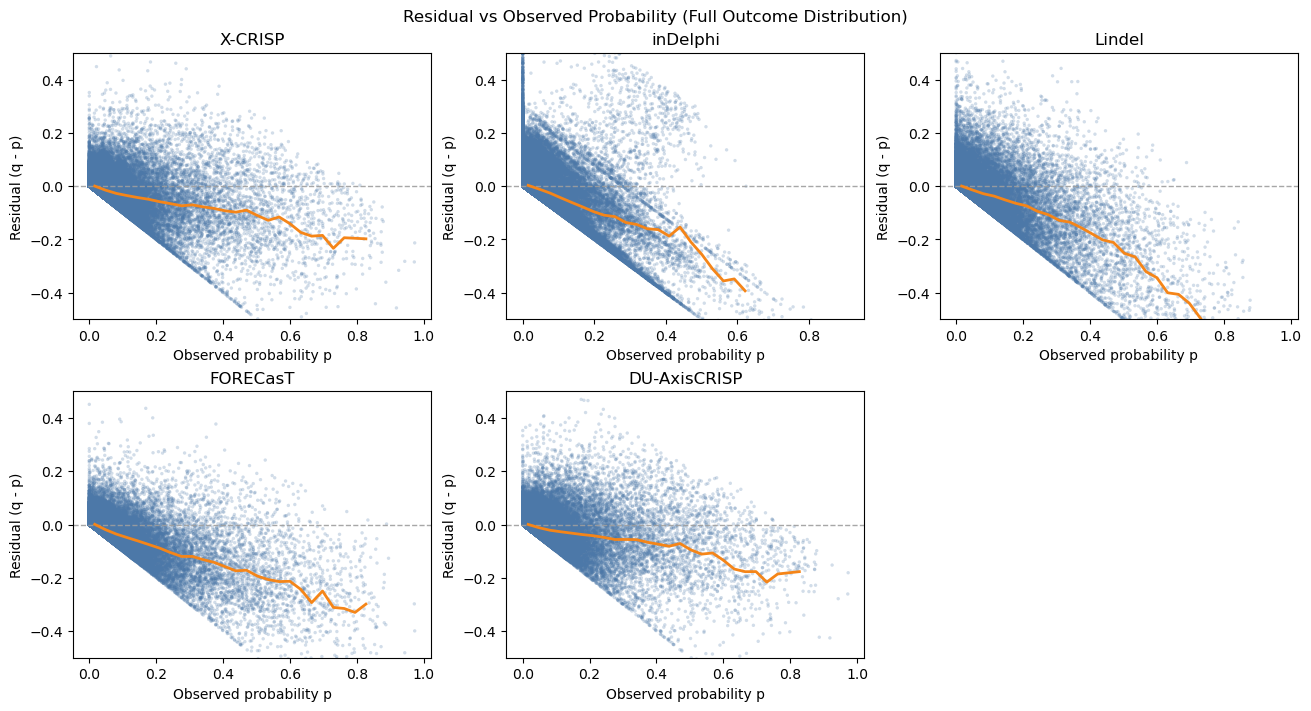

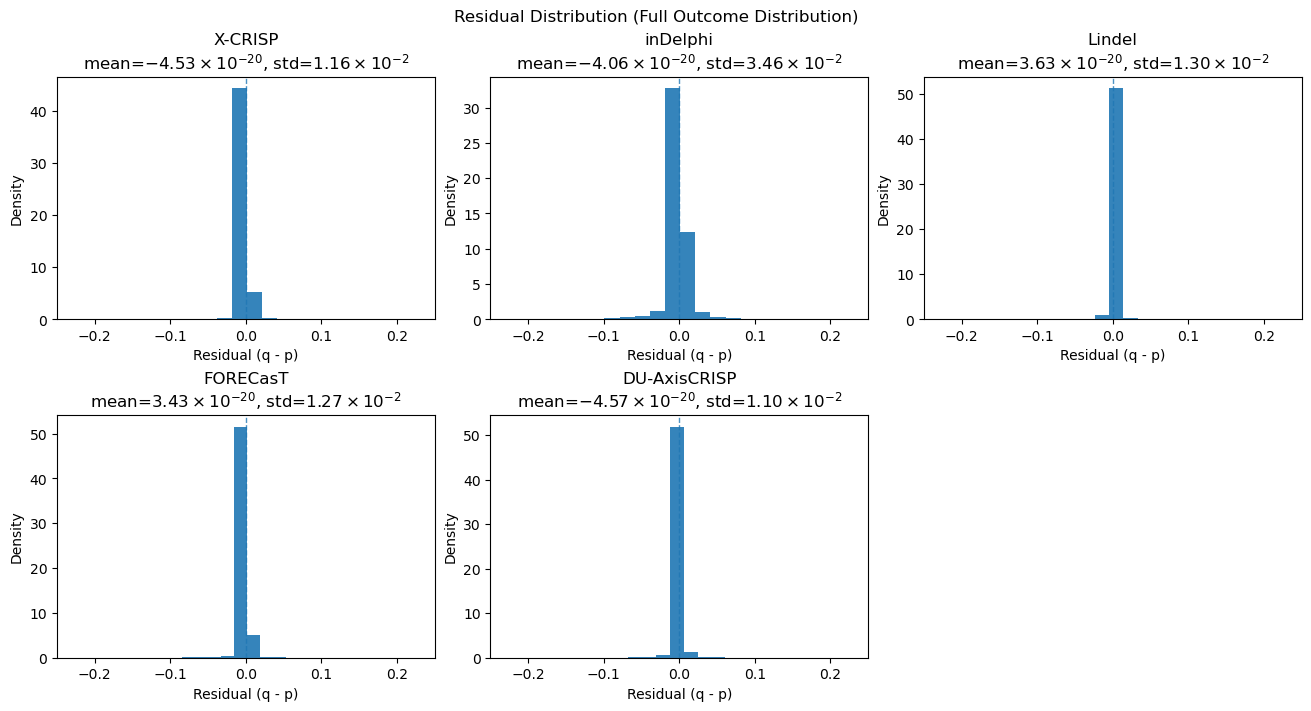

In [43]:
import numpy as np
import matplotlib.pyplot as plt

EPS = 1e-12

def _safe_norm(x):
    x = np.asarray(x, dtype=float)
    s = x.sum()
    if s <= 0:
        return None
    return x / s

def _gather_residuals_for_method(method, TEST_FILES, file_mapping, data, common_oligos):
    """收集该 method 在所有测试集/所有靶点上的 (p, q, r=q-p)。返回展平的一维数组。"""
    all_p = []
    all_q = []
    for t in TEST_FILES:
        for target in common_oligos[t]:
            q = np.asarray(data[t][method][target]["predicted"], dtype=float)
            p = np.asarray(data[t][method][target]["actual"],    dtype=float)
            p = _safe_norm(p); q = _safe_norm(q)
            if p is None or q is None or len(p) != len(q) or len(p) == 0:
                continue
            all_p.append(p)
            all_q.append(q)
    if not all_p:
        return None, None, None
    P = np.concatenate(all_p, axis=0)
    Q = np.concatenate(all_q, axis=0)
    R = Q - P
    return P, Q, R

def _binned_curve(x, y, nbins=30, min_count=10):
    """把 (x,y) 按 x 分箱，返回箱中心与 y 的均值（用于画趋势线）"""
    x = np.asarray(x); y = np.asarray(y)
    # 只保留有限值
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size == 0:
        return None, None
    bins = np.linspace(x.min(), x.max() + 1e-16, nbins + 1)
    idx = np.digitize(x, bins) - 1
    xs, ys = [], []
    for b in range(nbins):
        mask = (idx == b)
        if mask.sum() >= min_count:
            xs.append((bins[b] + bins[b+1]) / 2.0)
            ys.append(y[mask].mean())
    if len(xs) == 0:
        return None, None
    return np.array(xs), np.array(ys)
def sci_tex(x, digits=2):
    """把数字格式化成 a×10^{b} 的 LaTeX 形式；x=0 或非有限值则用普通格式。"""
    if not np.isfinite(x) or x == 0:
        return rf"${x:.{digits}g}$"
    s = f"{x:.{digits}e}"          # 例如 '-1.23e-04'
    base, exp = s.split('e')
    exp = int(exp)
    return rf"${base}\times 10^{{{exp}}}$"

def plot_full_distribution_residuals(TEST_FILES, file_mapping, data, common_oligos, models,
                                     scatter_alpha=0.08, nbins=30, figscale=(13, 7),
                                     ylim_res=(-0.5, 0.5), hist_bins=80):
    """
    生成两类图：
      图1：Residual (q-p) vs Observed p（2x3子图，最多放6个模型；>6自行调 grid）
      图2：Residual 直方图（同样的子图布局）
    """
    n_models = len(models)
    nrows, ncols = 2, 3
    if n_models > nrows * ncols:
        raise ValueError("当前布局最多容纳6个模型，请减少 models 或调整网格。")

    # -------- 图1：残差 vs 观测概率 --------
    fig1, axes1 = plt.subplots(nrows, ncols, figsize=figscale, constrained_layout=True)
    axes1 = axes1.ravel()
    for i, method in enumerate(models):
        P, Q, R = _gather_residuals_for_method(method, TEST_FILES, file_mapping, data, common_oligos)
        ax = axes1[i]
        if P is None:
            ax.set_title(f"{method} (no data)")
            ax.axis('off')
            continue
        point_color = "#4C78A8"   # 散点颜色（蓝）
        line_color  = "#F58518"   # 趋势线颜色（橙）
        zero_color  = "#9E9E9E"   # 0 线颜色（灰）
        # 散点（采样避免过密：可选）
        # 只画概率<=0.2的点更聚焦长尾；如需全量就改成 mask = slice(None)
        mask = np.ones_like(P, dtype=bool)  # = (P<=0.2)
        ax.scatter(P[mask], (Q-P)[mask], s=6, alpha=0.25, edgecolors='none',color=point_color)
        # 零线
        ax.axhline(0.0, lw=1, ls='--', alpha=0.9, color=zero_color)
        # 分箱均值曲线（趋势）
        bx, by = _binned_curve(P, (Q-P), nbins=nbins, min_count=30)
        if bx is not None:
            ax.plot(bx, by, lw=2, color=line_color)
        ax.set_title(method)
        ax.set_xlabel("Observed probability p")
        ax.set_ylabel("Residual (q - p)")
        ax.set_ylim(*ylim_res)
    # 把多余子图关掉
    for j in range(i+1, nrows*ncols):
        axes1[j].axis('off')
    fig1.suptitle("Residual vs Observed Probability (Full Outcome Distribution)")

    # -------- 图2：残差直方图 --------
    fig2, axes2 = plt.subplots(nrows, ncols, figsize=figscale, constrained_layout=True)
    axes2 = axes2.ravel()
    for i, method in enumerate(models):
        P, Q, R = _gather_residuals_for_method(method, TEST_FILES, file_mapping, data, common_oligos)
        ax = axes2[i]
        if R is None:
            ax.set_title(f"{method} (no data)")
            ax.axis('off')
            continue
        ax.hist(R[np.isfinite(R)], bins=hist_bins, density=True, alpha=0.9)
        ax.axvline(0.0, lw=1, ls='--', alpha=0.8)
        mu = float(np.nanmean(R))
        std = float(np.nanstd(R))
        ax.set_title(f"{method}\nmean={sci_tex(mu, 2)}, std={sci_tex(std, 2)}")
        ax.set_xlabel("Residual (q - p)")
        ax.set_ylabel("Density")
        ax.set_xlim(-0.25, 0.25)
    for j in range(i+1, nrows*ncols):
        axes2[j].axis('off')
    fig2.suptitle("Residual Distribution (Full Outcome Distribution)")

    plt.show()

# ===== 调用示例 =====
models = ["X-CRISP", "inDelphi", "Lindel", "FORECasT", "DU-AxisCRISP"]
plot_full_distribution_residuals(TEST_FILES, file_mapping, data, common_oligos, models)


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def bin_curve(p, r, bins=50, agg='sum_abs', normalize=False):
    """
    p: 观测概率向量
    r: 残差向量 (q - p)
    agg: 'sum_abs' | 'sum_l2' | 'sum_signed' | 'kl'
         - sum_abs:   ∑ |r|
         - sum_l2:    ∑ r^2
         - sum_signed:∑ r   （不常用，正负会抵消）
         - kl:        ∑ p * (log p - log q)  （需提供 q，可外面传 r 以外的 q/p 来改）
    normalize: 若 True，则对总量做归一化（按全体样本数），便于同轴显示
    """
    p = np.asarray(p, float)
    r = np.asarray(r, float)
    # 分箱
    edges = np.linspace(0, 1, bins + 1)
    idx = np.minimum(np.digitize(p, edges) - 1, bins - 1)
    # 聚合
    if agg == 'sum_abs':
        val_raw = np.bincount(idx, weights=np.abs(r), minlength=bins)
    elif agg == 'sum_l2':
        val_raw = np.bincount(idx, weights=r**2, minlength=bins)
    elif agg == 'sum_signed':
        val_raw = np.bincount(idx, weights=r, minlength=bins)
    elif agg=="sum":
        val_raw = np.bincount(idx, weights=r, minlength=bins)
    else:
        raise ValueError("agg not supported here; use 'sum_abs' or 'sum_l2'")

    counts = np.bincount(idx, minlength=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])

    if normalize:
        total = max(len(p), 1)
        val = val_raw / total
    else:
        val = val_raw

    return centers, val, counts

def plot_residual_scatter_with_sum_curve(ax, p, q, bins=50,
                                         curve_agg='sum_abs',
                                         normalize_curve=False,
                                         scatter_alpha=0.08):
    r = q - p
    # 散点（左轴）
    sc = ax.scatter(p, r, s=6, alpha=scatter_alpha, edgecolor='none')
    ax.axhline(0, ls='--', lw=1, color='#9aa0a6')
    # 可行域边界（可选，解释三角空白）
    xx = np.linspace(0, 1, 200)
    ax.plot(xx, -xx, ls='--', lw=0.8, color='#c7c9cc')
    ax.plot(xx, 1-xx, ls='--', lw=0.8, color='#c7c9cc')

    ax.set_xlabel("Observed probability p")
    ax.set_ylabel("Residual (q - p)")

    # 右轴：总残差曲线
    centers, sum_abs, counts = bin_curve(p, r=np.abs(q-p), bins=60, agg='sum', normalize=False)
    mae = sum_abs / np.maximum(counts, 1)

    rel_r = np.abs(q-p) / np.maximum(p, 1e-12)
    centers2, sum_rel, counts2 = bin_curve(p, rel_r, bins=60, agg='sum', normalize=False)
    rel_mae = sum_rel / np.maximum(counts2, 1)

    ax.plot(centers, mae, lw=2.0, color='#ff7f0e', label='MAE per bin')
    ax2 = ax.twinx()
    ax2.plot(centers2, rel_mae, lw=2.0, color='#2ca02c', label='Rel-MAE per bin')
    ax.set_xlim(0, 0.1)           # 放大尾部
    ax2.set_yscale('log')         # 相对误差跨量级，建议对数

    '''ax2 = ax.twinx()
    centers, curve, counts = bin_curve(p, r, bins=bins, agg=curve_agg, normalize=normalize_curve)
    ln, = ax2.plot(centers, curve, lw=2.0, color='#2b8a3e', label="Total residual ({}{})".format(
        {'sum_abs':'L1', 'sum_l2':'L2', 'sum_signed':'signed',"sum":""}[curve_agg],
        ", normalized" if normalize_curve else ""
    ))
    ax2.set_yscale('log')
    ax2.set_ylabel('Total residual (log)')
    #ax2.set_ylabel("Total residual per bin")
    # 图例：分别给点和线不同颜色
    ax.legend([ln], [ln.get_label()], loc='upper right')'''

    return ax, ax2
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.ravel()
models = ["X-CRISP", "inDelphi", "Lindel", "FORECasT", "DU-AxisCRISP"]
for i, method in enumerate(models):
    # 组装全体分布的 p, q（把所有 target 的类别拼起来）
    P_list, Q_list = [], []
    for t in TEST_FILES:
        for target in common_oligos[t]:
            p = np.asarray(data[t][method][target]["actual"], float)
            q = np.asarray(data[t][method][target]["predicted"], float)
            s_p, s_q = p.sum(), q.sum()
            if s_p > 0 and s_q > 0 and len(p) == len(q):
                P_list.append(p / s_p)
                Q_list.append(q / s_q)
    P = np.concatenate(P_list); Q = np.concatenate(Q_list)

    ax = axes[i]
    plot_residual_scatter_with_sum_curve(
        ax, P, Q,
        bins=60,
        curve_agg='sum_abs',       # 或 'sum_l2'
        normalize_curve=False      # 若想共轴显示，可改 True
    )
    ax.set_title(method)

# 去掉多余子图
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])
fig.suptitle("Residual vs Observed with TOTAL error curve (Full Outcome Distribution)")
plt.tight_layout()
plt.show()


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
})
plt.style.use("default")  # 只在外部设置一次

EPS = 1e-12

def _safe_norm(x):
    x = np.asarray(x, dtype=float)
    s = x.sum()
    if s <= 0:
        return None
    return x / s

def _tail_mask_by_mass(p, tail_mass):
    idx = np.argsort(-p)
    cum = np.cumsum(p[idx])
    tail_cut = (cum > (1.0 - tail_mass))
    m = np.zeros_like(p, dtype=bool)
    m[idx[tail_cut]] = True
    return m

def _gather_targets(TEST_FILES, data, common_oligos, method):
    out = []
    for t in TEST_FILES:
        for target in common_oligos[t]:
            p = _safe_norm(np.asarray(data[t][method][target]["actual"], dtype=float))
            q = _safe_norm(np.asarray(data[t][method][target]["predicted"], dtype=float))
            if p is None or q is None or len(p)!=len(q) or len(p)==0:
                continue
            out.append((p,q))
    return out

def _reduce(vals, mode="mean", weights=None):
    v = np.asarray(vals, float)
    v = v[np.isfinite(v)]
    if v.size==0: return np.nan
    if mode=="median": return float(np.median(v))
    if mode=="weighted" and weights is not None:
        w = np.asarray(weights, float)[:len(v)]
        w = np.clip(w, 0, None)
        s = w.sum()
        return float(np.sum(v*w)/s) if s>0 else float(np.mean(v))
    return float(np.mean(v))

def plot_tmr_vs_tail_mass_pretty(
    TEST_FILES, data, common_oligos, methods,
    tail_masses=None, reduce_mode="mean", weighted_by="P_tail",
    figsize=(11,5), ylog=True, save_path=None, show=True
):
    # 不要在这里再次 plt.style.use(...)
    tableau10 = ["#8ECFC9", "#96C37D", "#FA7F6F", "#F3D266", "#BEB8DC",
                 "#EDC948","#B07AA1","#FF9DA7","#9C755F","#BAB0AC"]

    if tail_masses is None:
        tm_dense = np.r_[np.logspace(np.log10(1), np.log10(0.01), 10),
                         0.008,0.006,0.005,0.004,0.003,0.002,0.001]
        tail_masses = np.unique(np.clip(tm_dense, 1e-4, 0.999))

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    for i, method in enumerate(methods):
        pq_list = _gather_targets(TEST_FILES, data, common_oligos, method)
        if not pq_list:
            continue
        color = tableau10[i % len(tableau10)]
        tmr_curve = []
        for m in tail_masses:
            vals, wts = [], []
            for (p,q) in pq_list:
                tail = _tail_mask_by_mass(p, m)
                P_tail = float((p[tail]).sum())
                Q_tail = float((q[tail]).sum())
                if P_tail <= 0:
                    continue
                vals.append(Q_tail / (P_tail + EPS))
                if reduce_mode=="weighted":
                    wts.append(P_tail if weighted_by=="P_tail" else int(tail.sum()))
            tmr_curve.append(_reduce(vals, mode=reduce_mode,
                                     weights=wts if reduce_mode=="weighted" else None))

        ax.plot(tail_masses, tmr_curve, label=method,
                color=color, lw=0.8, marker="o", markersize=3.5, alpha=0.95)

    if ylog:
        ax.set_yscale("log")
    ax.axhline(1.0, color="#888888", ls="--", lw=1)
    ax.grid(True, which="both", alpha=0.25, color="#BBBBBB", linestyle="--", linewidth=0.6)
    ax.set_xlabel(r"Tail mass budget $m$ (log scale) — tail = smallest $m$ of $P$")
    ax.set_ylabel(r"$\mathrm{TMR}(m)=\frac{\sum Q_{\text{tail}}}{\sum P_{\text{tail}}}$")
    leg = ax.legend(title="Model", frameon=True)
    leg.get_frame().set_edgecolor("#DDDDDD")
    leg.get_frame().set_alpha(0.95)

    plt.tight_layout()

    # 先保存，再 show；或返回 fig 给外部保存
    if save_path:
        fig.savefig(save_path, dpi=300, facecolor="white", bbox_inches="tight")
    if show:
        plt.show()
    return fig, ax
methods = ["X-CRISP","inDelphi","Lindel","FORECasT","DU-AxisCRISP"]
fig, ax = plot_tmr_vs_tail_mass_pretty(TEST_FILES, data, common_oligos, methods,
                                       save_path="E:/tmr_vs_tail_mass.png", show=False)
# 或者：fig.savefig("E:/tmr_vs_tail_mass.png", dpi=300, facecolor="white", bbox_inches="tight")


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False         # 不走外部 LaTeX
mpl.rcParams["mathtext.fontset"] = "stix"   # 稳定一点的数学字体
# --- 统一白底 ---
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
})
plt.style.use("default")

EPS = 1e-12

def _safe_norm(x):
    x = np.asarray(x, dtype=float)
    s = x.sum()
    if s <= 0:
        return None
    return x / s

def _gather_all_P(TEST_FILES, data, common_oligos):
    """从 data 聚合所有 target 的真实分布 P（一次性展平）。"""
    all_P = []
    for t in TEST_FILES:
        # 任选一个方法拿 'actual'（各方法应共享同一份观测）
        any_method = next(iter(data[t].keys()))
        for target in common_oligos[t]:
            p = _safe_norm(np.asarray(data[t][any_method][target]["actual"], dtype=float))
            if p is None or p.size == 0:
                continue
            all_P.append(p)
    if not all_P:
        return np.array([])
    return np.concatenate(all_P, axis=0)

def plot_observed_label_distribution(TEST_FILES, data, common_oligos,
                                     bins=60, pmin=1e-8, figsize=(11,4.5), save_path=None):
    P = _gather_all_P(TEST_FILES, data, common_oligos)
    assert P.size > 0, "没有可用的真实标签数据（P）。"

    # 拆分 P=0 与 P>0
    zero_mask = (P <= pmin)
    P_zero_mass = float(P[zero_mask].sum())
    P_pos = P[~zero_mask]
    if P_pos.size == 0:
        P_pos = np.array([1e-12])  # 避免报错

    # 准备阈值序列用于右图（分位-质量曲线）
    taus = np.r_[np.geomspace(1e-6, 1e-1, 30), 0.2, 0.3, 0.5, 0.8, 1.0]
    taus = np.unique(np.clip(taus, pmin, 1.0))
    mass_le_tau = []
    for tau in taus:
        # P<=tau 的总质量（包含近似 0 的部分）
        mass = float(P[P <= tau].sum())
        mass_le_tau.append(mass)

    # 画图
    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)

    # 图1：P>0 的直方图（对数 x 轴）
    ax = axes[0]
    ax.hist(P_pos, bins=bins, density=True, alpha=0.9, color="#4C78A8")
    #ax.set_xscale("log")
    ax.set_xlabel("Observed probability $P$ (log scale)")
    ax.set_ylabel("Density")
    ax.grid(True, which="both", alpha=0.25, linestyle="--", linewidth=0.6)
    # 在图内标注 P≈0 的总质量
    ax.text(0.02, 0.95, f"Mass at $P\\approx 0$: {P_zero_mass:.3e}",
            transform=ax.transAxes, va="top", ha="left", fontsize=10,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#DDDDDD"))

    # 图2：分位-质量曲线（\sum_{P_i \le \tau} P_i）
    ax = axes[1]
    ax.plot(taus, mass_le_tau, lw=1.6, color="#F58518", marker="o", markersize=3.0)
    ax.set_xscale("log")
    ax.set_xlabel(r"Threshold $\tau$ on $P$ (log scale)")
    ax.set_ylabel(r"Cumulative mass $\sum_{P_i \leq \tau} P_i$")
    ax.set_ylim(0, 1.0)
    ax.grid(True, which="both", alpha=0.25, linestyle="--", linewidth=0.6)
    ax.axhline(0.1, color="#999999", ls="--", lw=1)  # 参考：10% 质量
    ax.axhline(0.5, color="#BBBBBB", ls="--", lw=1)  # 参考：50% 质量

    fig.suptitle("Observed Label Distribution", y=1.02, fontsize=12)
    #if save_path:
    fig.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()

# 用法
plot_observed_label_distribution(TEST_FILES, data, common_oligos, save_path="E:/distribution.png")
